**Переда запуском добавь коко2014 [датасет](https://www.kaggle.com/datasets/nadaibrahim/coco2014) в ноутбук)**

In [ ]:
!pip install wandb
!pip install bitsandbytes
!pip install ruclip==0.0.2
!pip install transformers==4.27.4
!pip install pycocotools
!pip install git+https://github.com/openai/CLIP.git
!pip install open_clip_torch

#### Качаем РУССКИЙ капчеринг

In [ ]:
!ls /kaggle/working

In [ ]:
#!rm -rf ru_capt.json
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1uIO34T8d0ML23I30mcRFAD7niggm1kIt' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1uIO34T8d0ML23I30mcRFAD7niggm1kIt" -O ru_capt.json && rm -rf /tmp/cookies.txt

#### Качаем ембединги датасета

In [ ]:
#!rm -rf train2014_emb.zip
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=11OpNsXhmtafzItkGxaTqMXqgL2dQycl6' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=11OpNsXhmtafzItkGxaTqMXqgL2dQycl6" -O train2014_emb.zip && rm -rf /tmp/cookies.txt
#!unzip train2014_emb.zip

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1a6kvugo_mA0qwd_anIxFXD4pzot5B16t' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1a6kvugo_mA0qwd_anIxFXD4pzot5B16t" -O Features_train_coco_ru_vitb16_82783.pkl && rm -rf /tmp/cookies.txt




In [ ]:
#!rm -rf val2014_emb.zip
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1a-XuH0q5Ktlo6fIGFKQVkGEUkjiQ10X0' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1a-XuH0q5Ktlo6fIGFKQVkGEUkjiQ10X0" -O val2014_emb.zip && rm -rf /tmp/cookies.txt

!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1BbGw3TWSb_yspyX2TO0zU43IEE27VVin' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1BbGw3TWSb_yspyX2TO0zU43IEE27VVin" -O Features_val_coco_ru_vitb16.pkl && rm -rf /tmp/cookies.txt

#!unzip val2014_emb.zip


In [ ]:
import json
ru_capt = {}
with open('./ru_capt.json', 'r') as file:
    for st in file:
        data = json.loads(st)
        ru_capt[data['id']] = data
        

In [ ]:
len(ru_capt)

In [ ]:
import torchvision.datasets as dset
coco_train = dset.CocoDetection(
    root = "/kaggle/input/train2014/train2014",
    annFile = "/kaggle/input/captions/annotations/captions_train2014.json"
)
coco_val = dset.CocoDetection(
    root = "/kaggle/input/val2014/val2014",
    annFile = "/kaggle/input/captions/annotations/captions_val2014.json"
)

In [ ]:
# так и должно быть
len(ru_capt), len(coco_train), len(coco_val)

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as nnf
from torch.utils.data import Dataset, DataLoader


In [ ]:
from tqdm import tqdm, trange
import os
import pickle
import sys
import argparse
import json
from typing import Tuple, Optional, Union
from torch.cuda.amp import autocast

import ruclip
import clip, open_clip
import random

In [ ]:
from transformers import GPT2Config, GPT2Model
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
#from multilingual_clip import pt_multilingual_clip

In [ ]:
manualSeed = 1337
#manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
class MLP(nn.Module):
    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)
    
    @autocast()  
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

In [ ]:
def freeze(
    model,
    freeze_emb=False,
    freeze_ln=False,
    freeze_attn=True,
    freeze_ff=True,
    freeze_other=False,
):
    
    for name, p in model.named_parameters():
    # freeze all parameters except the layernorm and positional embeddings
        name = name.lower()
        if 'ln' in name or 'norm' in name:
            p.requires_grad = not freeze_ln
        elif 'embeddings' in name:
            p.requires_grad = not freeze_emb
        elif 'mlp' in name:
            p.requires_grad = not freeze_ff
        elif 'attn' in name:
            p.requires_grad = not freeze_attn
        else:
            p.requires_grad = not freeze_other
           
    return model

In [ ]:
gpt_model_name = 'sberbank-ai/rugpt3medium_based_on_gpt2'
class ClipCaptionModel(nn.Module):
    def __init__(self, prefix_length: int, prefix_size: int = 640):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length

        self.gpt = GPT2LMHeadModel.from_pretrained(gpt_model_name)
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]

        self.clip_project = MLP((
            prefix_size, 
            self.gpt_embedding_size * prefix_length // 2,
            self.gpt_embedding_size * prefix_length
        ))
        
    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)
    
    @autocast() 
    def forward(
        self,        
        tokens: torch.Tensor,
        prefix: torch.Tensor,
        mask: Optional[torch.Tensor] = None,
        labels: Optional[torch.Tensor] = None
    ):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix.float()).view(-1, self.prefix_length, self.gpt_embedding_size)

        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask, output_hidden_states = True)
        
        return out

In [ ]:
class ClipCaptionPrefix(ClipCaptionModel):
    def parameters(self, recurse: bool = True):
        return self.clip_project.parameters()

    def train(self, mode: bool = True):
        super(ClipCaptionPrefix, self).train(mode)
        self.gpt.eval()
        return self

In [ ]:
tokenizer = GPT2Tokenizer.from_pretrained(gpt_model_name)

In [ ]:
# запустится только с gpu, очень большая штука  --- LARGE же =)
#clip_model, processor = ruclip.load("ruclip-vit-large-patch14-336", device="cuda")
#clip_model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-plus-240', pretrained="laion400m_e32")
#clip_model.to(device)

# Получение эмбедингов изображений

In [ ]:
GET_EMBEDDING = False

In [ ]:
import io
import os
import PIL
import random
import numpy as np
import torch
import torchvision
import transformers
import more_itertools
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
from torch.utils.data import Dataset
from tqdm import tqdm
from dataclasses import dataclass, field
import torchvision.transforms as T
import torchvision.transforms.functional as TF
import cv2
from PIL import Image
import pickle
from tqdm.contrib import tzip

def read_image(path, size=(196, 196)):
    image = cv2.imread(path)
    
    # size = 196, 196
    image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    image.thumbnail(size, Image.Resampling.LANCZOS)
    
    return image

In [ ]:
read_image('/kaggle/input/train2014/train2014/COCO_train2014_000000000030.jpg')


In [ ]:
first = len(coco_train)//3
second = 2*len(coco_train)//3
third = len(coco_train)

steps = [(0, first), (first, second), (second, third)]

In [ ]:
if GET_EMBEDDING:
    all_embeddings = []
    all_captions = []
    all_image_id = []

    for start, stop in steps:
        for i in tqdm(range(start, stop)):

            #image = coco_train[i][0]

            name_img = str(coco_train[i][1][0]['image_id'])
            name_img = "0" * (12 - len(name_img)) + name_img
            path_img = f"/kaggle/input/train2014/train2014/COCO_train2014_{name_img}.jpg"

            image = read_image(path = path_img)
            image = preprocess(image).unsqueeze(0).to(device)
            with torch.no_grad():
                prefix = clip_model.encode_image(image).detach().to(device)

            for capt_sample in coco_train[i][1]:
                caption = ru_capt[capt_sample['id']]

                text = f"Вопрос: что на изображении? Ответ: {caption['caption']}"
                # TODO: более аккуратный вопрос

                all_captions.append(text)
                all_embeddings.append(prefix)
                all_image_id.append(name_img)

In [ ]:
out_path = f"Features_train_coco_ru_vitb16_82783.pkl"


In [ ]:
if GET_EMBEDDING:

    with open(out_path, 'wb') as f:
        pickle.dump({"clip_embedding": torch.cat(all_embeddings, dim=0), "captions": all_captions, 'image_id': all_image_id}, f)

    print('Done')
    print("%0d embeddings saved " % len(all_embeddings))


In [ ]:
if GET_EMBEDDING:

    all_embeddings = []
    all_captions = []
    all_image_id = []


    for i in tqdm(range(0, len(coco_val))):
        name_img = str(coco_val[i][1][0]['image_id'])
        name_img = "0" * (12 - len(name_img)) + name_img
        path_img = f"/kaggle/input/val2014/val2014/COCO_val2014_{name_img}.jpg"

        image = read_image(path = path_img)

        image = preprocess(image).unsqueeze(0).to(device)

        with torch.no_grad():
            prefix = clip_model.encode_image(image).detach().to(device)

        for capt_sample in coco_val[i][1]:
            caption = ru_capt[capt_sample['id']]

            text = f"Вопрос: что на изображении? Ответ: {caption['caption']}"
            # TODO: более аккуратный вопрос
            all_captions.append(text)
            all_embeddings.append(prefix)
            all_image_id.append(name_img)

In [154]:
coco_val[0]

(<PIL.Image.Image image mode=RGB size=640x478>,
 [{'image_id': 42,
   'id': 641613,
   'caption': 'This wire metal rack holds several pairs of shoes and sandals'},
  {'image_id': 42,
   'id': 645309,
   'caption': 'A dog sleeping on a show rack in the shoes.'},
  {'image_id': 42,
   'id': 650217,
   'caption': 'Various slides and other footwear rest in a metal basket outdoors.'},
  {'image_id': 42,
   'id': 650868,
   'caption': 'A small dog is curled up on top of the shoes'},
  {'image_id': 42,
   'id': 652383,
   'caption': 'a shoe rack with some shoes and a dog sleeping on them'}])

In [ ]:
val_out_path = "Features_val_coco_ru_vitb16.pkl"


In [ ]:
if GET_EMBEDDING:
    with open(val_out_path, 'wb') as f:
        pickle.dump({"clip_embedding": torch.cat(all_embeddings, dim=0), "captions": all_captions, 'image_id': all_image_id}, f)

    print('Done')
    print("%0d embeddings saved " % len(all_embeddings))


## Открыть данные

In [ ]:
out_path = f"Features_train_coco_ru_vitb16_82783.pkl"

In [ ]:
val_out_path = "Features_val_coco_ru_vitb16.pkl"

In [ ]:



import io
class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

        
        
        

In [ ]:
with open(out_path, 'rb') as f:
    embeddings_train = pickle.load(f)
    
  #  embeddings_train = CPU_Unpickler(f).load()
    


In [ ]:
with open(val_out_path, 'rb') as f:
    embeddings_val = pickle.load(f)
    
   # embeddings_val = CPU_Unpickler(f).load()


In [ ]:
len(embeddings_train['clip_embedding']), len(embeddings_train['captions'])

In [ ]:
len(embeddings_val['clip_embedding']), len(embeddings_val['captions'])

In [ ]:
path_emb_train_coco = f"Features_train_coco_ru_vitb16_82783.pkl"
path_emb_val_coco = f"Features_val_coco_ru_vitb16.pkl"

In [ ]:
import cv2
from PIL import Image

class ClipCocoDataset(Dataset):
    def __init__(
        self,
        data_path: str,
        prefix_length=30,
        model_type = gpt_model_name,
        normalize_prefix=False,
        train=True,
    ):

        self.tokenizer = GPT2Tokenizer.from_pretrained(model_type)
        self.prefix_length = prefix_length
        self.normalize_prefix = normalize_prefix
        self.train = train
        if train:
            with open(data_path, 'rb') as f:
                all_data = pickle.load(f)
            print("Data size is %0d" % len(all_data["clip_embedding"]))
        else:
            with open(data_path, 'rb') as f:
                all_data = pickle.load(f)
            print("Data size is %0d" % len(all_data["clip_embedding"]))

        sys.stdout.flush()
        self.prefixes = all_data["clip_embedding"]
        captions_raw = all_data["captions"]
        
        self.captions = captions_raw

        self.image_id = all_data["image_id"]
        
        self.captions_tokens = []
        self.caption2embedding = []
        max_seq_len = 0
        i = 0
        for caption in tqdm(captions_raw):
            self.captions_tokens.append(
                torch.tensor(self.tokenizer.encode(caption), dtype=torch.int64)
            )
            self.caption2embedding.append(self.prefixes[i])
            i += 1
            max_seq_len = max(max_seq_len, self.captions_tokens[-1].shape[0])

        all_len = torch.tensor([len(self.captions_tokens[i]) for i in range(len(self))]).float()
        self.max_seq_len = min(int(all_len.mean() + all_len.std() * 10), int(all_len.max()))

    def pad_tokens(self, item: int):
        tokens = self.captions_tokens[item]
        padding = self.max_seq_len - tokens.shape[0]
        if padding > 0:
            tokens = torch.cat((tokens, torch.zeros(padding, dtype=torch.int64) - 1))
           # self.captions_tokens[item] = tokens
        elif padding < 0:
            tokens = tokens[:self.max_seq_len]
           # self.captions_tokens[item] = tokens
        mask = tokens.ge(0)  # mask is zero where we out of sequence
        tokens[~mask] = 0
        mask = mask.float()
        mask = torch.cat((torch.ones(self.prefix_length), mask), dim=0)  # adding prefix mask
        return tokens, mask
    
    def get_image(self, item):
        if self.train:
            path_img = f"/kaggle/input/train2014/train2014/COCO_train2014_{self.image_id[item]}.jpg"
        else:
            path_img = f"/kaggle/input/val2014/val2014/COCO_val2014_{self.image_id[item]}.jpg"

        # path_img  =  '/kaggle/input/train2014/train2014/COCO_train2014_000000000030.jpg'
    
        image = cv2.imread(path_img)
        image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        image.thumbnail((196, 196), Image.Resampling.LANCZOS)
        return image
    
    def __len__(self) -> int:
        #if self.train:
        return len(self.captions_tokens)
        #else:
         #   return 5000

    def __getitem__(self, item):
        tokens, mask = self.pad_tokens(item)
        prefix = self.prefixes[item]
        if self.normalize_prefix:
            prefix = prefix.float()
            prefix = prefix / prefix.norm(2, -1)
        return tokens, mask, prefix

In [ ]:
torch.cuda.get_device_name(0)

In [ ]:
torch.cuda.mem_get_info()[1] / 1024**3

In [ ]:
import bitsandbytes as bnb

**Запусти ячейку и появится окошко для ввода токена)**

In [ ]:
class wandb:
    def log(*args, **kwargs):
        pass

In [ ]:
import wandb
wandb.login()

In [ ]:
import wandb

wandb.init(project="ClipCap_NAS", name= 'eager-microwave-4')

In [ ]:
!pip install evaluate
!pip install torchmetrics

In [ ]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers.optimization import Adafactor, AdafactorSchedule

import os
import pickle
import sys
import argparse
import evaluate

from typing import Tuple, Optional, Union
from torch.cuda.amp import autocast
import torch.nn.functional as F

In [ ]:
from torchmetrics.functional.multimodal import clip_score
from functools import partial
from torchvision import transforms
# clip_score_fn = partial(clip_score, model_name_or_path=clip_model)

# def calculate_clip_score(images, prompts):
#     transform = transforms.Compose([transforms.PILToTensor()])
#     images_int = transform(images)
#     clip_score = clip_score_fn(images_int, prompts).detach()
#     return round(float(clip_score), 4)



In [93]:
def supervised_train(
    train_dataset: ClipCocoDataset,
    valid_dataset: ClipCocoDataset,
    model: ClipCaptionModel,
    args,
    warmup_steps: int = 2000,
    output_dir: str = ".",
    output_prefix: str = ""
):
    #
    batch_size = args.bs
    epochs = args.epochs
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model = freeze(model)
    
    optimizer = Adafactor(
        model.parameters(),
        lr=args.lr,
        relative_step=False, # for adafactor
    )

    metric_dataset = valid_dataset

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    
    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
    )
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=epochs * len(train_dataloader)
    )
    
    #scheduler = AdafactorSchedule(optimizer) работает не оч

    mean_epoch_train_loss = []
    mean_epoch_validation_loss = []
    
    bleu_metric = []
    clipscore_metric = []
    
    bleu = evaluate.load("bleu")
    
    metric_len = 1000
    
    model.train()

    for epoch in range(epochs):
        loss_train_epoch = []
     #   loss_valid_epoch = []
        print(f">>> Training epoch {epoch+1}")
        sys.stdout.flush()
        progress = tqdm(total=len(train_dataloader), desc=output_prefix)
        step=0
        for idx, (tokens, mask, prefix) in enumerate(train_dataloader):
            model.zero_grad()
            step += 1
            tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.bfloat16)
            
            outputs = model(tokens, prefix, mask)
            logits = outputs.logits[:, train_dataset.prefix_length - 1: -1]

            probabilities = F.gumbel_softmax(logits, dim=-1)
            
            loss = nnf.cross_entropy(
                probabilities.reshape(-1, logits.shape[-1]),
                tokens.flatten().to(torch.int64),
                ignore_index=0
            )            
            
            loss.backward()
            optimizer.step()
            scheduler.step()

            optimizer.zero_grad()
            progress.set_postfix({"loss_train": loss.item()})
            
            loss_train_epoch.append(loss.item())

            if step % 500:
                wandb.log({"loss_train":  loss.item()})
            
            progress.update()
            if (idx + 1) % 7000 == 0:
                torch.save(
                    model.state_dict(),
                    os.path.join(output_dir, f"{output_prefix}_latest_gpt2_medium.pt"),
                )
                            
        progress.close()
        if epoch % args.save_every == 0:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{(epoch+1):03d}_gpt2_medium.pt"),
            )


        print(f">>> Metric {epoch+1}")
        
       # progress = tqdm(total=len(valid_dataloader), desc=output_prefix)
        progress = tqdm(total=metric_len, desc=output_prefix)
        step_validation=0
        bleu_result = 0
        clipscore_result = 0
        for idx, (tokens, mask, prefix) in enumerate(valid_dataloader):
            step_validation+=1
            
            if batch_size * step_validation >= metric_len:
                break
                
            with torch.no_grad():

                tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.bfloat16)
            
                outputs = model(
                        question_tokens, prefix, q_mask
                    )
                
                logits = outputs.logits

                for b in range(batch_size):

                    generated_text = valid_dataset.tokenizer.decode(logits[b].argmax(dim=-1).tolist())

                    bias = generated_text.find('Ответ: ')
                    if bias != -1:
                        generated_text = generated_text[bias+7:]
                    references = [valid_dataset.captions[idx * 2 + b][35:]]

                    bleu_result += bleu.compute(predictions=[generated_text], references=references)['bleu']
                   # clipscore_result += calculate_clip_score(metric_dataset.get_image(idx), generated_text)      
                

            progress.set_postfix({"bluescore_result": bleu_result/step_validation})

            #loss_valid_epoch.append(loss.item())
            if step_validation % 500:
                wandb.log({"bleu":  bleu_result/step_validation})
             #   wandb.log({"clipscore": clipscore_result/step_validation})

            progress.update()


        mean_epoch_train_loss.append(np.mean(loss_train_epoch))
        bleu_metric.append(bleu_result / metric_len)
       # clipscore_metric.append(clipscore_result / metric_len)

       # mean_epoch_validation_loss.append(np.mean(loss_valid_epoch))
        
      # wandb.log({"mean_epoch_validation_loss": mean_epoch_validation_loss[-1]})
        wandb.log({"mean_epoch_train_loss": mean_epoch_train_loss[-1]})
    #    wandb.log({"epoch_clipscope": clipscore_metric[-1]})
        wandb.log({"epoch_blue": bleu_metric[-1]})

        progress.close()        
        
    return model



In [ ]:
class Args():
    def __init__(self):
        self.backbone = gpt_model_name
        self.train_data = "Features_train_coco_ru_vitb16_82783.pkl"
        self.valid_data = "Features_val_coco_ru_vitb16.pkl"
        self.out_dir = 'checkpoints'
        self.prefix = 'first_start'
        self.epochs = 2
        self.save_every = 1
        self.prefix_length = 30
        self.bs = 2
        self.only_prefix = False
        self.lr = 2e-5
args = Args()

In [ ]:
train_dataset = ClipCocoDataset(args.train_data, args.prefix_length, train=True)
valid_dataset = ClipCocoDataset(args.valid_data, args.prefix_length, train=False)

In [137]:
len(train_dataset), len(valid_dataset)

(414113, 202626)

In [ ]:
question_tokens = torch.tensor(tokenizer.encode("Вопрос: что на изображении? Ответ:"), dtype=torch.int64)
question_tokens = torch.cat((question_tokens, torch.zeros(valid_dataset.max_seq_len - question_tokens.shape[0], dtype=torch.int64) - 1))
q_mask = question_tokens.ge(0)  # mask is zero where we out of sequence
question_tokens[~q_mask] = 0
q_mask = q_mask.float()
q_mask = torch.cat((torch.ones(valid_dataset.prefix_length), q_mask), dim=0)  # adding prefix mask
question_tokens = torch.stack([question_tokens] * args.bs).to(device)
q_mask = torch.stack([q_mask] * args.bs).to(device)
#question_tokens = question_tokens.unsqueeze(0).to(device)

In [ ]:
from torch.utils.data import random_split
sup_train_dataset, unsup_train_dataset = random_split(train_dataset, [0.025, 0.975], generator=torch.Generator().manual_seed(manualSeed))

In [ ]:
sup_train_dataset.prefix_length = train_dataset.prefix_length
unsup_train_dataset.prefix_length = train_dataset.prefix_length

In [138]:
len(sup_train_dataset), len(unsup_train_dataset)

(10353, 403760)

In [ ]:
wandb.config = {
  "learning_rate": args.lr,
  "epochs": args.epochs,
  "batch_size": args.bs
}

model = ClipCaptionModel(args.prefix_length)
model = model.to(device)

In [111]:
with torch.no_grad():
    tokens, mask, prefix = valid_dataset[0]
    tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.bfloat16)
    outputs = model(
            question_tokens[0].unsqueeze(0), prefix, q_mask[0].unsqueeze(0)
        )
   
    logits = outputs.logits

    generated_text = valid_dataset.tokenizer.decode(logits[0].argmax(dim=-1).tolist())[35:]
    bias = generated_text.find('Ответ: ')
    if bias != -1:
        generated_text = generated_text[bias+7:]
    references = [valid_dataset.captions[0 * 2 + 0][35:]]
    
    print(generated_text)
    print(references)

на. девушка автомобиль, автомобиль девушка. девушка изображение девушка девушка человек человек. девушка девушка.. мужчина мужчина женщина. мужчина девушка. девушка.. девушка автобус автомобиль. мужчина мужчина стол стол человек автомобиль.. девушка.. автомобиль мужчина женщина. автомобиль.. девушка девушка. девушка женщина мужчина
['Приготовление блюд из брокколи и хлеба.']


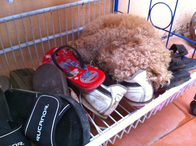

In [146]:
valid_dataset.get_image(0)

In [ ]:
bleu = evaluate.load("bleu")

In [97]:
!ls /kaggle/working/checkpoints

first_start-001_gpt2_medium.pt


In [96]:
!rm /kaggle/working/first_start-001_gpt2_medium.pt

In [98]:
!mv /kaggle/working/checkpoints/first_start-001_gpt2_medium.pt /kaggle/working/


In [99]:
!zip /kaggle/working/checkpoints/first_start-001_gpt2_medium.pt


zip error: Nothing to do! (/kaggle/working/checkpoints/first_start-001_gpt2_medium.pt)


In [ ]:
modelpath = 'first_start-001_gpt2_medium.pt'
model.load_state_dict(torch.load(modelpath)) 

In [94]:
torch.cuda.empty_cache()

In [92]:
print("Train both prefix and GPT2")
sys.stdout.flush()
model = supervised_train(
    sup_train_dataset,
    valid_dataset,
    model,
    args,
    output_dir=args.out_dir,
    output_prefix=args.prefix,
)



first_start:  99%|█████████▉| 5140/5176 [21:32<00:09,  3.96it/s, loss_train=10.3]

first_start:  99%|█████████▉| 5141/5176 [21:32<00:08,  3.98it/s, loss_train=10.3]

first_start:  99%|█████████▉| 5141/5176 [21:32<00:08,  3.98it/s, loss_train=10.3]

first_start:  99%|█████████▉| 5142/5176 [21:32<00:08,  3.95it/s, loss_train=10.3]

first_start:  99%|█████████▉| 5142/5176 [21:33<00:08,  3.95it/s, loss_train=10.2]

first_start:  99%|█████████▉| 5143/5176 [21:33<00:08,  3.97it/s, loss_train=10.2]

first_start:  99%|█████████▉| 5143/5176 [21:33<00:08,  3.97it/s, loss_train=10.3]

first_start:  99%|█████████▉| 5144/5176 [21:33<00:08,  3.99it/s, loss_train=10.3]

first_start:  99%|█████████▉| 5144/5176 [21:33<00:08,  3.99it/s, loss_train=10.3]

first_start:  99%|█████████▉| 5145/5176 [21:33<00:07,  4.00it/s, loss_train=10.3]

first_start:  99%|█████████▉| 5145/5176 [21:33<00:07,  4.00it/s, loss_train=10.3]

first_start:  99%|█████████▉| 5146/5176 [21:33<00:07,  4.00it/s, loss_train=10.3]

fi

>>> Metric 1




first_start:   0%|          | 0/1000 [00:00<?, ?it/s]

first_start:   0%|          | 0/1000 [00:02<?, ?it/s, bluescore_result=0]

NameError: name 'loss_valid_epoch' is not defined

In [ ]:
def unsupervised_train(
    train_dataset: ClipCocoDataset,
    valid_dataset: ClipCocoDataset,
    model: ClipCaptionModel,
    args,
    warmup_steps: int = 2000,
    output_dir: str = ".",
    output_prefix: str = ""
):
    #
    batch_size = args.bs
    epochs = args.epochs
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    model = freeze(model)
    
    optimizer = Adafactor(
        model.parameters(),
        lr=args.lr,
        relative_step=False, # for adafactor
    )

    metric_dataset = valid_dataset

    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
    )
    
    valid_dataloader = DataLoader(
        valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
    )
    
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=warmup_steps,
        num_training_steps=epochs * len(train_dataloader)
    )
    
    #scheduler = AdafactorSchedule(optimizer) работает не оч

    mean_epoch_train_loss = []
    mean_epoch_validation_loss = []
    
    bleu_metric = []
    clipscore_metric = []
    
    bleu = evaluate.load("bleu")
    metric_len = 1000

        
    model.train()

    for epoch in range(epochs):
        loss_train_epoch = []
     #   loss_valid_epoch = []
        print(f">>> Training epoch {epoch+1}")
        sys.stdout.flush()
        progress = tqdm(total=len(train_dataloader), desc=output_prefix)
        step=0
        for idx, (tokens, mask, prefix) in enumerate(train_dataloader):
            model.zero_grad()
            step += 1
            tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.bfloat16)
            
            outputs = model(tokens, prefix, mask)

            last_hiddens_state = outputs.hidden_states[-1]
            image_emb = model.clip_project(prefix.float()).view(-1, model.prefix_length, model.gpt_embedding_size)
            embedding_text = model.gpt.transformer.wte(tokens)
            image_emb = torch.cat((image_emb, embedding_text), dim=1)
            loss = - torch.sum(F.cosine_similarity(image_emb,
                                                   last_hiddens_state, dim=-1))
            loss.backward()
            optimizer.step()
            scheduler.step()

            optimizer.zero_grad()
            progress.set_postfix({"loss_train": loss.item()})
            
            loss_train_epoch.append(loss.item())

            if step % 500:
                wandb.log({"unsupervised_loss_train":  loss.item()})
            
            progress.update()
            if (idx + 1) % 7000 == 0:
                torch.save(
                    model.state_dict(),
                    os.path.join(output_dir, f"{output_prefix}_latest_gpt2_medium.pt"),
                )
                
                
        progress.close()
        if epoch % args.save_every == 0:
            torch.save(
                model.state_dict(),
                os.path.join(output_dir, f"{output_prefix}-{(epoch+1):03d}_gpt2_medium.pt"),
            )


        print(f">>> Metric {epoch+1}")
        
        progress = tqdm(total=metric_len, desc=output_prefix)
        step_validation=0
        bleu_result = 0
        clipscore_result = 0
        for idx, (tokens, mask, prefix) in enumerate(valid_dataloader):
            step_validation+=1
            if step_validation * batch_size >= metric_len:
                break
            with torch.no_grad():

                tokens, mask, prefix = tokens.to(device), mask.to(device), prefix.to(device, dtype=torch.bfloat16)
            
                
                outputs = model(
                        question_tokens, prefix, q_mask
                    )
                
                logits = outputs.logits

                for b in range(batch_size):

                    generated_text = valid_dataset.tokenizer.decode(logits[b].argmax(dim=-1).tolist())

                    bias = generated_text.find('Ответ: ')
                    if bias != -1:
                        generated_text = generated_text[bias+7:]
                    references = [valid_dataset.captions[idx * 2 + b][35:]]

                    bleu_result += bleu.compute(predictions=[generated_text], references=references)['bleu']
                   # clipscore_result += calculate_clip_score(metric_dataset.get_image(idx), generated_text)      
                

            progress.set_postfix({"blue_result": bleu_result/step_validation})

            #loss_valid_epoch.append(loss.item())
            if step_validation % 500:
                wandb.log({"unsupervised_bleu":  bleu_result/step_validation})
              #  wandb.log({"clipscore": clipscore_result/step_validation})

            progress.update()


        mean_epoch_train_loss.append(np.mean(loss_train_epoch))
        bleu_metric.append(bleu_result / metric_len)
     #   clipscore_metric.append(clipscore_result / metric_len)

       # mean_epoch_validation_loss.append(np.mean(loss_valid_epoch))
        
      # wandb.log({"mean_epoch_validation_loss": mean_epoch_validation_loss[-1]})
        wandb.log({"unsupervised_mean_epoch_train_loss": mean_epoch_train_loss[-1]})
      #  wandb.log({"epoch_clipscope": clipscore_metric[-1]})
        wandb.log({"unsupervised_epoch_blue": bleu_metric[-1]})

        progress.close()
        
        
    return model



In [ ]:
print("Train both prefix and GPT2")
sys.stdout.flush()
model = unsupervised_train(
    unsup_train_dataset,
    valid_dataset,
    model,
    args,
    output_dir=args.out_dir,
    output_prefix=args.prefix
)